In [376]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt

In [377]:
model = cobra.io.read_sbml_model('models/e_coli/momentiJO1366.xml')
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

In [378]:
met_info_df = pd.read_csv("met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)

In [379]:
met_info_df

,Metabolite name,Metabolite id,Value,Uncertainty,Mass,Charge,Phosphate,Topological Polar Surface Area [Å],Concentration
0,Glucose-6-phosphate,g6p,17.65,0.53,258.119901,-2.0,1,165.000000,0.003000
1,Fructose-6-phosphate,f6p,29.29,0.60,258.119901,-2.0,1,165.000000,0.003000
2,"Fructose-1,6-bisphosphate",fdp,34.21,0.72,336.083922,-4.0,2,215.000000,0.015200
3,Dihydroxyacetonephosphate,dhap,50.40,1.74,168.041961,-2.0,1,104.000000,0.000374
4,Glyceraldehyde-3-phosphate,g3p,15.04,0.24,168.041961,-2.0,1,104.000000,NaN
5,2/3-phosphoglycerate,"2pg, 3pg",19.45,1.55,183.033421,-3.0,1,124.000000,0.001540
6,Phosphoenolpyruvate,pep,20.43,0.28,165.018141,-3.0,1,104.000000,0.000184
7,Pyruvate,pyr,4924.00,509.00,87.054120,-1.0,0,57.200000,NaN
8,6-Phosphogluconate,6pgc,0.00,0.00,273.111361,-3.0,1,185.000000,0.003770
9,Ribose-5-phosphate,r5p,10.29,0.22,228.093921,-2.0,1,137.000000,0.000450


# Get shadow prices and turnover flux

In [380]:
def get_turnover_flux(m, solution):
    total_flux = 0
    for r in m.reactions:
        flux_r = solution.fluxes[r.id]*r.get_coefficient(m_id)
        if flux_r > 0:
            total_flux += flux_r
    return total_flux


In [381]:
# FBA
# I choose glucose uptake so low that there is no overflow metabolism
glucose_uptake = 10
model.reactions.EX_glc__D_e.lower_bound = -glucose_uptake
solution = model.optimize()

shadow_prices = {}
turnover = {}
for i, row in met_info_df.iterrows():
    m_text = row["Metabolite id"]
    try:
        keys = m_text.split(",")
    except:
        print(m_text)
        continue
    sp_list = []
    turnover_list = []
    for key in keys:
        m_id = "{0}_c".format(key.strip())
        m = model.metabolites.get_by_id(m_id)
        sp_list.append(solution.shadow_prices[m.id])
        turnover_list.append(get_turnover_flux(m, solution))
    shadow_prices[i] = np.mean(sp_list)
    turnover[i] = np.mean(turnover_list)

In [382]:
# With glucose uptake = 3, there is a small flux "inconcistency" with accoa, gicing a positive shadow price
with model:
    model.add_boundary(model.metabolites.accoa_c, "demand")
    model.optimize()
    print(model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.6436981589523789

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00335         0   0.00%
      cl_e      EX_cl_e   0.00335         0   0.00%
 cobalt2_e EX_cobalt2_e 1.609E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004564         0   0.00%
     fe2_e     EX_fe2_e   0.01034         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1256         0   0.00%
     mg2_e     EX_mg2_e  0.005584         0   0.00%
     mn2_e     EX_mn2_e 0.0004448         0   0.00%
    mobd_e    EX_mobd_e 8.304E-05         0   0.00%
     nh4_e     EX_nh4_e     6.952         0   0.00%
     ni2_e     EX_ni2_e 0.0002079         0   0.00%
      o2_e      EX_o2_e      17.6         0   0.00%
      pi_e      EX_pi_e    0.6209         0   0.00%
     so4_e     EX_so4_e    0.1623         0   0.00%
     zn2_e     EX_zn2_e 0.0002195  

In [383]:
met_info_df["Shadow price"] = pd.Series(shadow_prices)
met_info_df["Turnover"] = pd.Series(turnover)

In [384]:
met_info_df

,Metabolite name,Metabolite id,Value,Uncertainty,Mass,Charge,Phosphate,Topological Polar Surface Area [Å],Concentration,Shadow price,Turnover
0,Glucose-6-phosphate,g6p,17.65,0.53,258.119901,-2.0,1,165.000000,0.003000,-0.017544,10.000000
1,Fructose-6-phosphate,f6p,29.29,0.60,258.119901,-2.0,1,165.000000,0.003000,-0.017632,2.460728
2,"Fructose-1,6-bisphosphate",fdp,34.21,0.72,336.083922,-4.0,2,215.000000,0.015200,-0.024706,2.277172
3,Dihydroxyacetonephosphate,dhap,50.40,1.74,168.041961,-2.0,1,104.000000,0.000374,-0.014695,2.277172
4,Glyceraldehyde-3-phosphate,g3p,15.04,0.24,168.041961,-2.0,1,104.000000,NaN,-0.014699,11.535426
5,2/3-phosphoglycerate,"2pg, 3pg",19.45,1.55,183.033421,-3.0,1,124.000000,0.001540,-0.009357,10.752714
6,Phosphoenolpyruvate,pep,20.43,0.28,165.018141,-3.0,1,104.000000,0.000184,-0.010589,10.217296
7,Pyruvate,pyr,4924.00,509.00,87.054120,-1.0,0,57.200000,NaN,-0.004273,17.005051
8,6-Phosphogluconate,6pgc,0.00,0.00,273.111361,-3.0,1,185.000000,0.003770,-0.017517,7.662006
9,Ribose-5-phosphate,r5p,10.29,0.22,228.093921,-2.0,1,137.000000,0.000450,-0.017209,0.723669


# Make predictions

In [385]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ARDRegression, BayesianRidge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from scipy import stats



In [386]:
met_info_df = met_info_df.loc[met_info_df.Value != 0, :]
met_info_df = met_info_df.loc[~met_info_df.Concentration.isna(), :]
met_info_df["log10_value"] = np.log10(met_info_df.Value)

In [387]:

met_info_df["log10_sp"] = np.log10(np.abs(met_info_df[["Shadow price"]]))
met_info_df["log10_conc"] = np.abs(np.log10(met_info_df.Concentration))

In [388]:
columns = ["log10_sp", "log10_conc", "Turnover", "Mass", "Charge", "Phosphate", "Topological Polar Surface Area [Å]", "Shadow price", "Concentration"]



## Make train and test set

In [389]:
data = StandardScaler().fit_transform(met_info_df[columns])
X_train, X_test, y_train, y_test = train_test_split(data, met_info_df.log10_value, test_size=0.1)#, random_state=40)


In [390]:
N = 20
coefficients = np.zeros((9,N))*np.nan

R2_arr = np.zeros(N)
R2_arr_test = np.zeros(N)
data = StandardScaler().fit_transform(met_info_df[columns])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, met_info_df.log10_value, test_size=0.05)
    linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    coefficients[:, i] = linear_reg.coef_
    R2_arr[i] = linear_reg.score(X_train, y_train)


In [391]:
len(coefficients.mean(axis = 1)), len(columns)

(9, 9)

<BarContainer object of 9 artists>

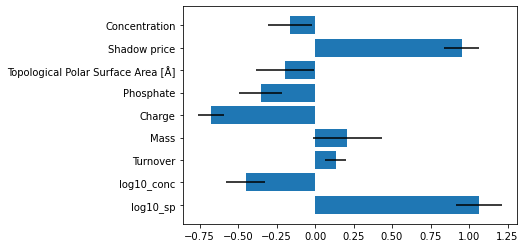

In [392]:
plt.barh(columns, coefficients.mean(axis=1), xerr = coefficients.std(axis=1))

<BarContainer object of 1 artists>

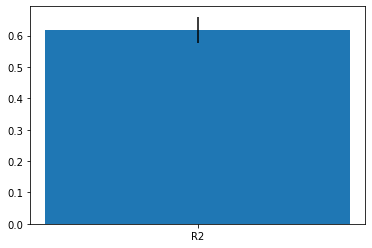

In [393]:
plt.bar(["R2"], [R2_arr.mean()], yerr = [R2_arr.std()])

# Test multiple different linear models

In [394]:
columns =  ["log10_sp", "log10_conc", "Turnover", "Mass", "Charge", "Phosphate", "Topological Polar Surface Area [Å]", "Shadow price", "Concentration"]

In [395]:
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs,n) for n in range(len(xs)+1))



In [396]:
all_sets = [list(x) for x in powerset(columns) if len(x)]

In [397]:
all_sets[:3]

[['log10_sp'], ['log10_conc'], ['Turnover']]

In [398]:
def adj_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [399]:
R2_mean = np.zeros(len(all_sets))
R2_adj = np.zeros(len(all_sets))
R2_std = np.zeros(len(all_sets))
loo = LeaveOneOut()

for i, model in enumerate(all_sets):
    temp_arr = np.zeros(data.shape[0])
    data = StandardScaler().fit_transform(met_info_df[model])
    for j, (train_index, test_index) in enumerate(loo.split(data)):
        X = data[train_index, :]
        y =  met_info_df.log10_value.values[train_index]
        linear_reg = LinearRegression(fit_intercept = True).fit(X, y)
        #coefficients[:, i] = linear_reg.coef_
        temp_arr[j] = linear_reg.score(X, y)
    R2_mean[i] = temp_arr.mean()
    R2_adj[i] = adj_r2(temp_arr.mean(), len(temp_arr), len(model))
    R2_std[i] = temp_arr.std()

In [400]:
idx = R2_mean.argsort()

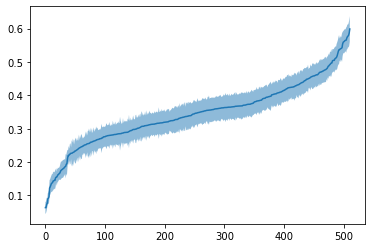

In [401]:
plt.plot(np.arange(len(idx)), R2_mean[idx])
plt.fill_between(np.arange(len(idx)), R2_mean[idx]-R2_std[idx], R2_mean[idx]+R2_std[idx], alpha = 0.5)

# Statsmodels

In [402]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [461]:
columns =  ["Turnover", "Mass", "Charge", "Phosphate", "Topological Polar Surface Area [Å]","log10_sp", "log10_conc", "Shadow price", "Concentration"]
columns =  ["log10_sp", "Charge"] #"log10_value" "Topological Polar Surface Area [Å]", 
data = StandardScaler().fit_transform(met_info_df[columns])

In [462]:
df = met_info_df[columns]
rho = df.corr()
pval = df.corr(method=lambda x, y: st.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,log10_sp,Charge
log10_sp,1.0***,0.68***
Charge,0.68***,1.0***


In [463]:
pval

,log10_sp,Charge
log10_sp,0.000000,0.000258
Charge,0.000258,0.000000


In [464]:
data = sm.add_constant(data)

In [465]:
data.shape, y.size

((24, 3), 24)

In [466]:
y = StandardScaler().fit_transform(met_info_df.log10_value.values[:, np.newaxis])

In [467]:
y.std()

0.9999999999999999

In [468]:
ols_model = sm.OLS(y, data)

In [469]:
results = ols_model.fit()

In [459]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     3.947
Date:                Wed, 01 Feb 2023   Prob (F-statistic):             0.0351
Time:                        22:02:31   Log-Likelihood:                -30.226
No. Observations:                  24   AIC:                             66.45
Df Residuals:                      21   BIC:                             69.99
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.608e-16      0.186   1.94e-15      1.0

# Define function to estimate confidence intervals

## Linear model

In [46]:
linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [47]:
lin_pred = linear_reg.predict(X_test)

In [48]:
print(linear_reg.score(X_train, y_train))
print(linear_reg.score(X_test, y_test))

0.5907492757084257
-9.095159365904392


<BarContainer object of 9 artists>

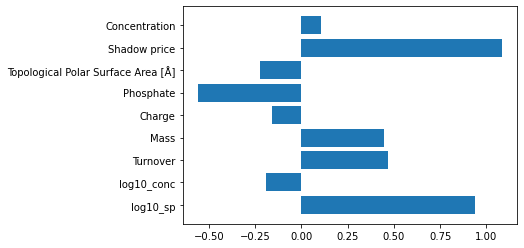

In [49]:
plt.barh(columns , linear_reg.coef_)

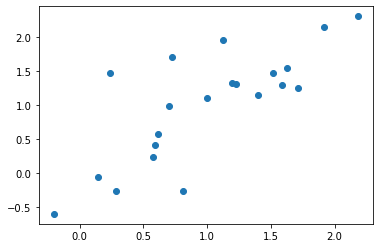

In [50]:
plt.scatter(linear_reg.predict(X_train), y_train)

## Lasso

In [101]:
lasso_reg = Lasso(fit_intercept = True, alpha = 0.01).fit(X_train, y_train)

In [102]:
print(lasso_reg.score(X_train, y_train))
print(lasso_reg.score(X_test, y_test))

0.5250520051066176
-0.8797249606779154


<BarContainer object of 9 artists>

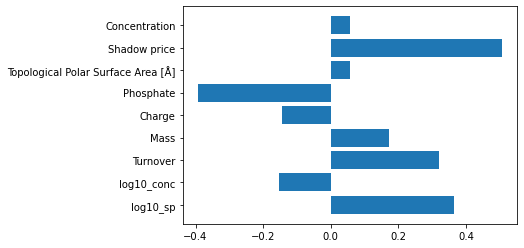

In [103]:
plt.barh(columns , lasso_reg.coef_)

# Elastic net

In [104]:
EN_reg = ElasticNet(alpha = 0.001).fit(X_train, y_train)

In [105]:
EN_pred = EN_reg.predict(X_test)
print(EN_reg.score(X_train, y_train))
print(EN_reg.score(X_test, y_test))

0.5519544494592639
-0.7916547292200444


<BarContainer object of 9 artists>

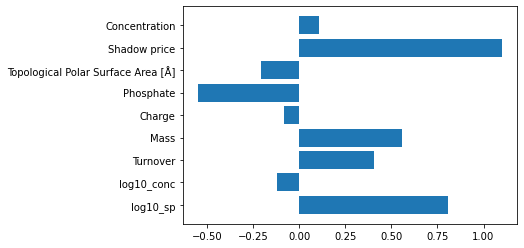

In [106]:
plt.barh(columns , EN_reg.coef_)

## Random forest

In [107]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)

In [108]:
rf_pred = rf_reg.predict(X_test)

In [109]:
print(rf_reg.score(X_train, y_train))
print(rf_reg.score(X_test, y_test))

0.8362749519440748
-0.30360344294761665


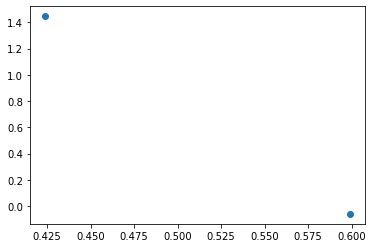

In [110]:
plt.scatter(rf_pred, y_test)

## Decision tree

In [111]:
tree_reg = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [112]:
tree_pred = tree_reg.predict(X_test)

In [113]:
print(tree_reg.score(X_train, y_train))
print(tree_reg.score(X_test, y_test))

1.0
-1.7847951830410511


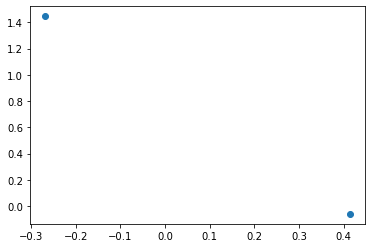

In [114]:
plt.scatter(tree_pred, y_test)

In [620]:
ard_reg = BayesianRidge(alpha_init=0.1, lambda_init=0.01).fit(X_train, y_train)

In [621]:
print(ard_reg.score(X_train, y_train))
print(ard_reg.score(X_test, y_test))

0.2371674184227759
0.6841950788118464


In [115]:
from sklearn.neural_network import MLPRegressor

In [116]:
MLP_reg = MLPRegressor(max_iter = 1000).fit(X_train, y_train)

In [117]:
print(MLP_reg.score(X_train, y_train))
print(MLP_reg.score(X_test, y_test))

0.971017731554102
-1.4007027411130735


[array([[ 0.18013351, -0.18151567,  0.12642034, -0.05617019,  0.00987986,
          0.00731731,  0.15084528,  0.09732818,  0.09153956, -0.07128596,
          0.25849024, -0.23289872, -0.04644276, -0.01279582,  0.15689094,
          0.31508104, -0.01638097,  0.30301362, -0.01731219, -0.18855022,
          0.17952468, -0.09144234, -0.19555564, -0.12586062,  0.15982066,
          0.1345942 ,  0.18493138,  0.23957611,  0.00478899, -0.03106493,
          0.17839147, -0.02238844,  0.31277231, -0.14683018,  0.09904009,
         -0.00179072, -0.17942071, -0.05809929,  0.12016301, -0.12260145,
          0.07941516,  0.04842748, -0.1038866 ,  0.09002151,  0.26457866,
         -0.1043415 , -0.06652327, -0.11799308, -0.30485799, -0.04079448,
          0.09851252, -0.1716397 , -0.00731401, -0.23605771, -0.06021398,
         -0.01207341, -0.11827515, -0.15948293, -0.09148907, -0.07882032,
         -0.046759  , -0.23048956,  0.11800451, -0.18926228,  0.10650232,
         -0.17340069,  0.00392482, -0.